## Import


In [1]:
%load_ext autoreload
%autoreload 2
from model import (
    load_features,
    train_egarch,
    forecast_egarch,
    evaluate_models
)
from feature_engineering import engineer_features
from data_ingestion import get_data
import pandas as pd
import numpy as np
from config import VOL_WINDOW, VOL_TARGET_HORIZON, DATA_RAW, TEST_SIZE,RESULTS_DIR
import matplotlib.pyplot as plt
from data_ingestion import get_sentiment_data

c:\Users\hp\Financial-volatility-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data 

In [2]:
df = get_data()

⚠️ Data is outdated (Last date: 2026-01-23). Re-downloading...


c:\Users\hp\Financial-volatility-forecasting\.venv\Lib\site-packages\yfinance\scrapers\history.py:201: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()
[*********************100%***********************]  1 of 1 completed


✅ Data saved to C:\Users\hp\Financial-volatility-forecasting\data\raw\SPY.csv


In [3]:
sentiment_df = get_sentiment_data()


 Fetching multi-source FinBERT news sentiment...
✅ 13 headlines | 3 sources
 News sentiment: 3 days

 Fetching Google Trends data...
 Google Trends: 93 days

 Creating daily volatility CSV...
✅ daily_vol.csv created (8293 days)

 Combining sentiment sources...
✅ Combined sentiment saved: 93 days


## feature engineering

In [4]:
df = engineer_features(df, sentiment_df, VOL_WINDOW, VOL_TARGET_HORIZON)

✅ Processed data saved. Range: 1993-03-02 to 2026-01-23


In [5]:
df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 8282 entries, 1993-03-02 to 2026-01-23
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Close                        8282 non-null   float64
 1   High                         8282 non-null   float64
 2   Low                          8282 non-null   float64
 3   Open                         8282 non-null   float64
 4   Volume                       8282 non-null   int64  
 5   log_return                   8282 non-null   float64
 6   volatility_20d               8282 non-null   float64
 7   abs_return                   8282 non-null   float64
 8   return_squared               8282 non-null   float64
 9   lag_1                        8282 non-null   float64
 10  lag_5                        8282 non-null   float64
 11  lag_10                       8282 non-null   float64
 12  lag_20                       8282 non-null   float64
 13  rolling_abs

In [6]:
df = load_features()
returns = df["log_return"]
target = df["target_volatility"]
sentiment = df["sentiment_lag1"]

In [7]:
print(f"Engineered data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Engineered data shape: (8282, 18)
Columns: ['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'volatility_20d', 'abs_return', 'return_squared', 'lag_1', 'lag_5', 'lag_10', 'lag_20', 'rolling_abs_return_mean_20d', 'sentiment', 'sentiment_lag1', 'sentiment_scaled', 'target_volatility']


## split

### Separate the historical data from the live data

In [8]:
historical_df = df.dropna(subset=['target_volatility'])
live_df = df.iloc[-20:] # These are the 20 rows with NaN targets

In [ ]:

# 80/20 split on ONLY the historical data for training and testing
split_idx = int(len(df) * (1 - TEST_SIZE))

returns_test = df["log_return"].iloc[split_idx:]
returns_train = df["log_return"].iloc[:split_idx]
target_test = df["target_volatility"].iloc[split_idx:]
# target_train is not needed for GARCH because it's unsupervised and only uses returns

In [10]:
print(f"\nTrain size: {len(returns_train)}, Test size: {len(returns_test)}")



Train size: 6625, Test size: 1657


In [11]:
print(f"Test Set NaNs: {target_test.isna().sum()}")

Test Set NaNs: 20


## Rolling egarch loop (parallel to GARCH)

In [ ]:
egarch_preds = []
print("\n Running Rolling EGARCH-X with sentiment...")

# Loops over each day in the test period, one day at a time. Retrains daily as GARCH is lightweight
for t in range(len(returns_test)):
    if t % 50 == 0:
        print(f"Progress: {t}/{len(returns_test)}")

    # Training Window (Grows by 1 each day)
    # This includes all data from 1993 up to the day BEFORE the test day
    r_train = returns.iloc[:split_idx + t]
    x_train = sentiment.iloc[:split_idx + t].values.reshape(-1,1)

    # Train Model
    model = train_egarch(r_train, x_train)

    # 3. Forecast for the NEXT period
    # We use the sentiment available at the end of the training window
    # to predict the volatility of the test period
    x_next = sentiment.iloc[[split_idx + t]].values.reshape(-1, 1)
    
    try:
        pred = forecast_egarch(model, x_next)
        egarch_preds.append(pred)
    except:
        # Fallback to previous prediction if solver fails
        egarch_preds.append(egarch_preds[-1] if egarch_preds else 0)

print(" EGARCH forecasting complete")


 Running Rolling EGARCH-X with sentiment...
Progress: 0/1657
Progress: 50/1657
Progress: 100/1657
Progress: 150/1657
Progress: 200/1657
Progress: 250/1657
Progress: 300/1657
Progress: 350/1657
Progress: 400/1657
Progress: 450/1657
Progress: 500/1657
Progress: 550/1657
Progress: 600/1657
Progress: 650/1657
Progress: 700/1657
Progress: 750/1657
Progress: 800/1657
Progress: 850/1657
Progress: 900/1657
Progress: 950/1657
Progress: 1000/1657
Progress: 1050/1657
Progress: 1100/1657
Progress: 1150/1657
Progress: 1200/1657
Progress: 1250/1657
Progress: 1300/1657
Progress: 1350/1657
Progress: 1400/1657
Progress: 1450/1657
Progress: 1500/1657
Progress: 1550/1657
Progress: 1600/1657
Progress: 1650/1657
 EGARCH forecasting complete


## Evaluate

In [15]:
print(model.params)

# const = Mean equation intercept (average return)
# x0 = Sentiment impact (how much sentiment affects volatility)
# omega = Baseline volatility(long-term average)
# alpha[1] = shock persistence (how much new shocks impact volatility)
# gamma[1] = leverage effect (In the stock market, bad news (negative returns) usually spikes volatility much harder than good news (positive returns) drops it)
# beta[1] = volatility persistence (how much past volatility influences future volatility)


Const       0.037256
x0          0.094935
omega       0.001009
alpha[1]    0.159924
gamma[1]   -0.142624
beta[1]     0.970173
Name: params, dtype: float64


In [ ]:
# Convert preds to a Series so we can align it with the index
preds_series = pd.Series(egarch_preds, index=target_test.index)

# Filter out the NaNs from the ground truth (the last 20 days)
# This keeps only the rows where we have an actual target to compare against
valid_mask = ~target_test.isna()

y_true_filtered = target_test[valid_mask].values
y_pred_filtered = preds_series[valid_mask].values

# run the evaluation on the CLEAN data
metrics = evaluate_models(
    y_true=y_true_filtered,
    y_pred=y_pred_filtered,
    model_name="EGARCH"
)

print(f"\n EGARCH Historical Performance (Excluding 2026 NaNs):")
print(f"  RMSE: {metrics['rmse']:.4f}")
print(f"  MAE: {metrics['mae']:.4f}")
print(f"  R²: {metrics['R_squared']:.4f}")



 EGARCH Performance:
 RMSE: 0.0978
 MAE: 0.0572
 R-squared: 0.2744

 EGARCH Historical Performance (Excluding 2026 NaNs):
  RMSE: 0.0978
  MAE: 0.0572
  R²: 0.2744

 LIVE FORECAST for the next 20 days: 0.1412


## Save Predictions

In [18]:
egarch_preds_df = pd.DataFrame({
    "actual_volatility": target_test, # This will have NaNs for 2026
    "egarch_forecast": egarch_preds,       # This will have numbers for 2026
}, index=target_test.index)

egarch_preds_df.to_csv(RESULTS_DIR / "preds" / "egarch_preds.csv", index=True)
print(f"\n✅ Predictions saved with dates to {RESULTS_DIR / 'preds' / 'egarch_preds.csv'}")


✅ Predictions saved with dates to C:\Users\hp\Financial-volatility-forecasting\results\preds\egarch_preds.csv


## EGARCH-X: Forecast vs True volatility

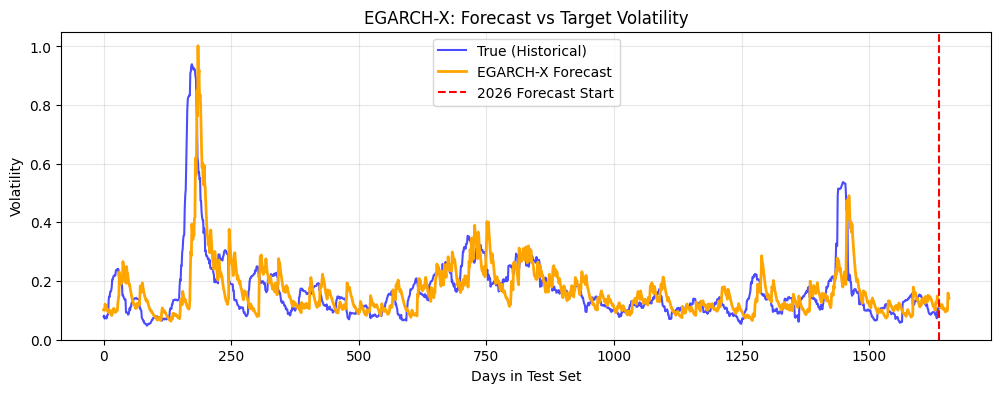

In [22]:
plt.figure(figsize=(12, 4))

# 1. Plot True Volatility (only the historical part, hide the 2026 NaNs)
mask = ~target_test.isna()
plt.plot(target_test[mask].values, label="True (Historical)", alpha=0.7, color='blue')

# 2. Plot EGARCH Predictions (Full range, including the 2026 forecast)
# Converting to numpy array to ensure plotting works correctly with the true values
plt.plot(np.array(egarch_preds), label="EGARCH-X Forecast", color='orange', linewidth=2)

# 3. Add the vertical line where the "Future" begins
# This is usually len(target_test) - 20
plt.axvline(x=len(target_test[mask]), color='red', linestyle='--', label='2026 Forecast Start')

plt.title("EGARCH-X: Forecast vs Target Volatility")
plt.xlabel("Days in Test Set")
plt.ylabel("Volatility")
plt.legend()
plt.grid(alpha=0.3)

# Save to the egarch folder
plt.savefig(f"{RESULTS_DIR}/figures/egarch/EGARCH_predicted_vs_True_Volatility.png", dpi=300, bbox_inches="tight")

## Save Metrics

In [21]:
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(RESULTS_DIR / "metrics" / "egarch_metrics.csv", index=False)
print(f"\n✅ EGARCH Metrics saved to {RESULTS_DIR / 'metrics' / 'egarch_metrics.csv'}")


✅ EGARCH Metrics saved to C:\Users\hp\Financial-volatility-forecasting\results\metrics\egarch_metrics.csv
